In [382]:
import numpy as np
from astropy import wcs
from astropy.io import fits
import sys
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
import seaborn as sns
import numpy as np
from astropy.time import Time
from os import listdir
from os.path import isfile, join

path = '/Users/alexgagliano/Documents/Research/2020oi/data/fits_files/SidingSprings/2020oi/'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

%matplotlib inline

In [ ]:
#some pretty plotting routines
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")

plt.rcParams['xtick.major.size'] = 16
plt.rcParams['ytick.major.size'] = 16

plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.minor.size'] = 8
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

cols = sns.color_palette("colorblind", 10)
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7]])

In [383]:
def points_in_circle_np(radius, x0=0, y0=0, ):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    for x, y in zip(x_[x], y_[y]):
        yield x, y

def calc_circle(N, radius, x0, y0):
    theta = np.linspace(0, 2*np.pi, num=N)
    x_fin = radius * np.sin(theta)+x0
    y_fin = radius * np.cos(theta)+y0
    return x_fin, y_fin

In [384]:
file_photometry = {'u':{}, 'g':{}, 'B':{}, 'V':{}, 'r':{}, 'i':{}, 'z':{}}
dates = {'u':[], 'g':[], 'B':[], 'V':[], 'r':[], 'i':[], 'z':[]}

SN20oi_ra = [185.728875]
SN20oi_dec = [+15.8236] #coords of 2020oi
source_ra = [185.7288829]
source_dec = [15.8223040] #coords of M100

#convert distance between two points 
c1 = SkyCoord(SN20oi_ra[0]*u.deg,SN20oi_dec[0]*u.deg, frame='icrs')
c2 = SkyCoord(source_ra[0]*u.deg,source_dec[0]*u.deg, frame='icrs')

sep = c1.separation(c2)
scale_SS = 0.3890000 #''/px; pixel scale of Siding Springs
sep_px = sep.arcsec/scale_SS 

#the number of apertures
N = 12 

ra_set = []
dec_set = []
for filename in onlyfiles:
    fn = path + filename
    band = fn.split("/")[-1].split(".")[1]
    band = band[0] #only get the first letter of the filter
    uniqueID = fn.split("/")[-1].split(".")[4]
    #print(fn)
    hdulist = fits.open(fn,ignore_missing_end=True)
    w = wcs.WCS(hdulist[0].header)
    image_data = hdulist[0].data
    
    px = w.wcs_world2pix(source_ra[0], source_dec[0], 1)
    px_20oi = w.wcs_world2pix(SN20oi_ra[0], SN20oi_dec[0], 1)
    
    #calculate circle around the center pixel, knowing the pixel scale on panstarrs is 0.25''/px
    #how far away is 2020oi from its center? 4.76'', and that's ~19 pixels from the center!
    x, y = calc_circle(N, sep_px, px[0], px[1])
    
    #don't get too close to 2020oi
    dist = np.sqrt((x - px_20oi[0])**2 + (y - px_20oi[1])**2)
    
    x = np.array(x)
    y = np.array(y)
    
    x = x[dist > 5] #don't use this aperture if we're within 5 pixels of 20oi
    y = y[dist > 5]
    
    tempCoords = w.wcs_pix2world(x, y, 1)
    
    tempRA = tempCoords[0]
    tempDEC = tempCoords[1]
    
    ra_set.append(tempRA)
    dec_set.append(tempDEC)
    
    positions = [x, y]
    aperture = CircularAperture(positions, r=2)
    
    phot_table = aperture_photometry(image_data, aperture)
    phot_df = phot_table.to_pandas()
    date = hdulist[0].header['DATE-OBS']
    file_photometry[band][filename] = phot_df
    dates[band].append(date)
    
    #write to regions file for plotting later
    #open image
    #write in the format
    f = open("%s_apertures.reg"%fn, "w")
    for i in np.arange(len(x)):
        f.write("image;circle(%.3f,%.3f,2) # color=blue\n" % (x[i], y[i]))
    f.write("image;circle(%.3f,%.3f,2) # color=red\n" % (px_20oi[0], px_20oi[1])) #mark the location of 20oi
    f.close()

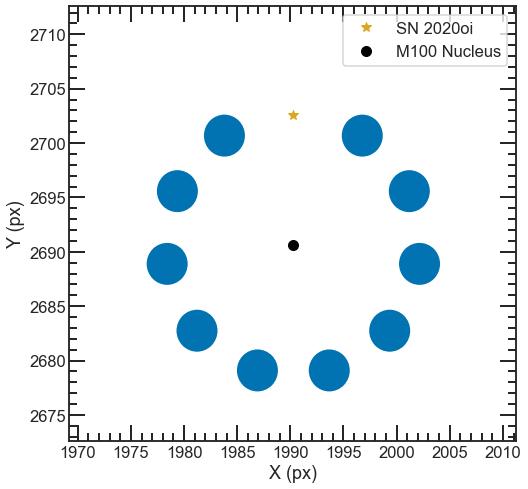

In [385]:
from matplotlib.patches import Circle

plt.figure(figsize=(8, 8))
ax = plt.gca()
for xx,yy in zip(x,y):
    circ = Circle((xx,yy),2)
    ax.add_patch(circ)
    
plt.plot(px_20oi[0], px_20oi[1], '*', label='SN 2020oi', ms=10, c='goldenrod', zorder=1000)
plt.xlim((px_20oi[0]-21, px_20oi[0]+21))
plt.ylim((px_20oi[1]-30, px_20oi[1]+10)) 
#plot nucleus of 20oi
plt.plot(px[0], px[1], 'o', ms=10, label='M100 Nucleus', c='k')
plt.xlabel("X (px)");
plt.ylabel("Y (px)");
plt.legend()
plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/forcedPhotometry.png", dpi=200)
plt.show()

In [386]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils import CircularAperture
from photutils import aperture_photometry

#make sure that all apertures are the same distance as 2020oi from the nucleus -- about 4.67''
c1 = SkyCoord(source_ra*u.deg, source_dec*u.deg, frame='icrs')
for i in np.arange(len(ra_arr)):
    c2 = SkyCoord(ra_set[i]*u.deg,dec_set[i]*u.deg, frame='icrs')
    print(c1.separation(c2).arcsec)

[4.6723982  4.67239819 4.67239818 4.67239818 4.67239819 4.6723982
 4.67239819 4.67239819 4.6723982  4.6723982 ]
[4.67861684 4.67861679 4.67861679 4.67861683 4.67861688 4.67861688
 4.67861684 4.67861682 4.67861684 4.67861687]
[4.67222001 4.67222    4.67222    4.67222001 4.67222002 4.67222002
 4.67222002 4.67222002 4.67222002 4.67222001]
[4.67606659 4.6760666  4.6760666  4.67606659 4.67606659 4.67606659
 4.67606658 4.67606658 4.67606658 4.67606659]
[4.68040103 4.68040105 4.68040097 4.68040089 4.68040091 4.68040098
 4.68040086 4.68040082 4.68040091 4.68040103]
[4.67529916 4.67529916 4.67529916 4.67529916 4.67529916 4.67529916
 4.67529916 4.67529916 4.67529916 4.67529916]
[4.68017341 4.68017336 4.68017336 4.68017341 4.68017346 4.68017345
 4.68017341 4.68017339 4.68017342 4.68017346]
[4.67706469 4.67706471 4.67706469 4.67706467 4.67706468 4.67706469
 4.67706465 4.67706464 4.67706466 4.67706469]
[4.67605513 4.67605514 4.67605515 4.67605514 4.67605514 4.67605514
 4.67605514 4.67605513 4.67605

In [387]:
#nice, I'm calling that a win. 

In [388]:
f = {'u':[],'g':[],'B':[],'V':[],'r':[],'i':[],'z':[]}

#first, just look at sigma(N)/median(N)
for flt in f.keys():
    for value in files[flt].values():
        tempVals = value['aperture_sum'].values
        f[flt].append(np.nanstd(tempVals)/np.nanmedian(tempVals))
        
#turn to pandas dataframe 
for flt in f.keys():
    tempDF = pd.DataFrame({'FLT':[flt]*len(f[flt]), 'UTC':dates[flt], 'COUNT_ERR': f[flt]})
    if flt== 'u':
        dfs = tempDF
    else:
        dfs = dfs.append(tempDF)

In [389]:
#convert dates from UTC to MJD
t = np.array([Time(x, format='isot', scale='utc') for x in dfs['UTC'].values])
MJD = np.array([x.mjd for x in t])
dfs['MJD'] = MJD

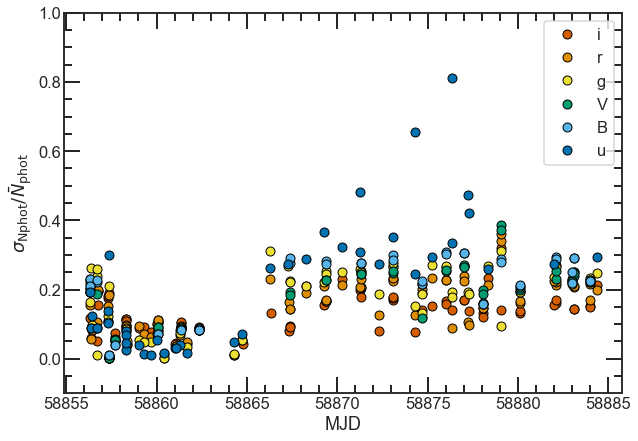

In [390]:
plt.figure(figsize=(10,7))
i = 0
for flt in np.flip(['u', 'B', 'V', 'g', 'r', 'i']):
    tempDF = dfs[dfs['FLT'] == flt]
    plt.plot(tempDF['MJD'], tempDF['COUNT_ERR'], 'o', c=cols[i], mec='k', label=flt)
    i+= 1
plt.xlabel("MJD")
plt.ylabel(r"$\sigma_{\rm Nphot}/\bar N_{\rm phot}$")
plt.legend()
plt.ylim((-0.1, 1))
plt.savefig("PhotometryUncertainty_RawSidingSpring.png",dpi=200)
plt.show()

In [391]:
dfs = []
r = 2 #aperture radius in px
Npx = np.pi*r**2 #px in each aperture

#loops over bands
for flt in files.keys():
    oneBand = files[flt]
    f = []
    #loops over images -- each "value" here is a set of apertures across one image
    for value in oneBand.values():
        tempVals = value['aperture_sum'].values
        mean = np.nanmean(tempVals)
        std = np.std(tempVals)
        red_chisq = (1./Npx)*np.nansum(np.abs(tempVals - mean)**2/std**2)
        fac = 1/np.sqrt(red_chisq)
        f.append(fac)
    df_flt = pd.DataFrame({'Date': np.array(dates[flt]), 'Band': np.array(len(dates[flt])*[flt]), 'f':np.array(f)})
    dfs.append(df_flt)

fullDF = pd.concat(dfs, ignore_index=True)
fullDF.dropna(inplace=True)

In [392]:
#convert the times in this df from UTC to MJD
t = Time([str(x) for x in fullDF['Date'].values], format='isot', scale='utc')
fullDF['MJD'] = t.mjd

In [402]:
#see what the scaling factor looks like 
np.unique(fullDF['f'])

array([1.12099824, 1.12099824, 1.12099824, 1.12099824])

Should the values really be this consistent??

In [393]:
fullDF.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/forcedPhotometry_errorScaling.csv", index=False)